## Time Series Forecasting project using ARIMA (Autoregressive integrated moving average) Model in Python

pip install yfinance

### Time Series Forecasting with ARIMA - JPMorgan Chase (JPM) Stock Analysis

In [8]:
import yfinance as yf
data = yf.download('JPM', start='2018-01-01') 
print(data.tail())

[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open    Volume
Ticker             JPM         JPM         JPM         JPM       JPM
Date                                                                
2025-04-21  228.990005  231.809998  226.339996  230.630005   8716200
2025-04-22  235.589996  235.990005  231.369995  231.979996  10701400
2025-04-23  240.880005  246.789993  240.000000  240.220001  14126800
2025-04-24  244.639999  245.470001  237.580002  239.740005   9055200
2025-04-25  243.550003  245.619995  241.750000  244.649994   8586800


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
# Display first 5 rows
print("First 5 rows of dataset:")
print(data.head())

First 5 rows of dataset:
Price           Close       High        Low       Open    Volume
Ticker            JPM        JPM        JPM        JPM       JPM
Date                                                            
2018-01-02  87.571869  87.628654  86.647071  87.312277  13578800
2018-01-03  87.661125  88.009953  87.190619  87.498882  11901000
2018-01-04  88.916908  89.724204  88.231925  88.362401  12953700
2018-01-05  88.346092  89.332795  87.889441  89.096313  14155000
2018-01-08  88.476570  88.623352  87.824206  88.191163  12466500


In [19]:
# Check data summary and missing values
print("\nData summary:\n")
print(data.info())
print("\nMissing values check:\n")
print(data.isnull().sum())


Data summary:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1839 entries, 2018-01-02 to 2025-04-25
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   (Close, JPM)   1839 non-null   float64
 1   (High, JPM)    1839 non-null   float64
 2   (Low, JPM)     1839 non-null   float64
 3   (Open, JPM)    1839 non-null   float64
 4   (Volume, JPM)  1839 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 86.2 KB
None

Missing values check:

Price   Ticker
Close   JPM       0
High    JPM       0
Low     JPM       0
Open    JPM       0
Volume  JPM       0
dtype: int64


###  Exploratory Data Analysis (EDA)

<Figure size 1200x600 with 0 Axes>

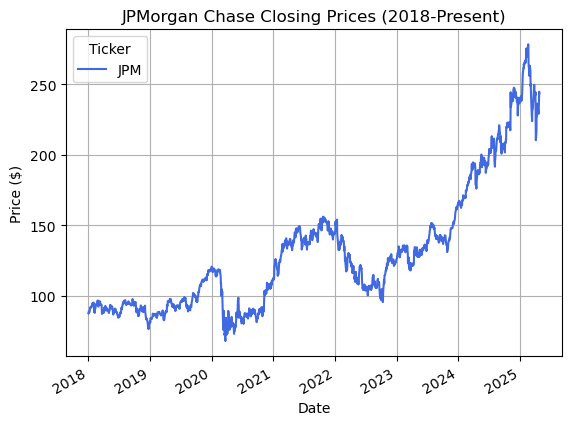

In [22]:
# Plot closing price time series
plt.figure(figsize=(12, 6))
data['Close'].plot(color='royalblue')
plt.title('JPMorgan Chase Closing Prices (2018-Present)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(True)
plt.show()

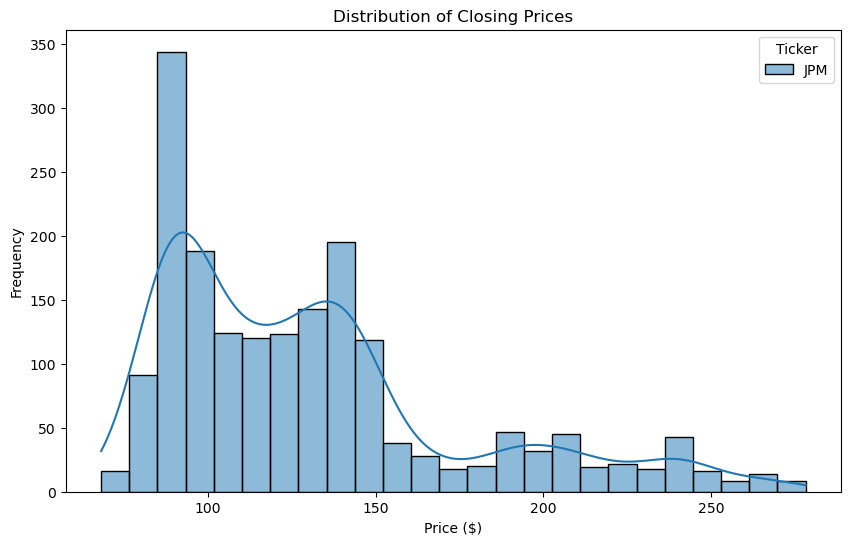

In [24]:
# Distribution plot of closing prices
plt.figure(figsize=(10, 6))
sns.histplot(data['Close'], kde=True, color='green')
plt.title('Distribution of Closing Prices')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.show()

In [29]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy import stats

 ###  Stationarity Check

In [32]:
# Perform Augmented Dickey-Fuller test to check if time series is stationary or non stationary
adf_result = adfuller(data['Close'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print(f'Critical Values: {adf_result[4]}')

ADF Statistic: 0.17621283007903984
p-value: 0.9708954387847087
Critical Values: {'1%': -3.433928413331545, '5%': -2.8631206697362663, '10%': -2.567611494520589}


#### Since the p-value is high (> 0.05) , the series is non-stationary
#### So we need to difference it (subtract previous values) until it becomes stationary.

In [38]:
# Difference the data 
data['Close_diff'] = data['Close'].diff().dropna()

In [40]:
# Re-run ADF test on differenced data
adf_diff = adfuller(data['Close_diff'].dropna())
print(f'\nADF Statistic (Differenced): {adf_diff[0]} \n')
print(f'p-value (Differenced): {adf_diff[1]}')


ADF Statistic (Differenced): -15.435344390044513 

p-value (Differenced): 2.9120430093798564e-28


###  Time Series Decomposition
#### To split the time series into Trend (long-term movement up or down), Seasonality (regular repeating pattern every fixed period),  Residuals (what’s left — the noise or randomness)

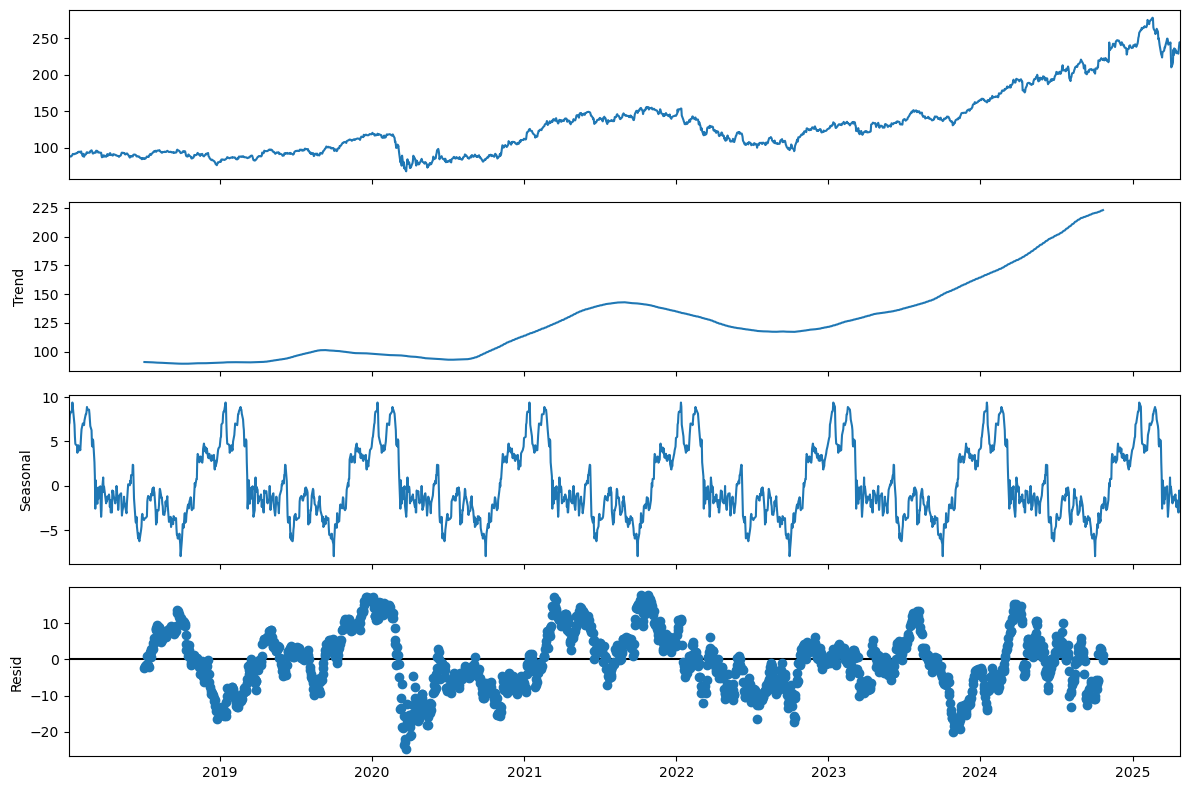

In [45]:
# Additive decomposition
decomposition = seasonal_decompose(data['Close'], model='additive', period=252)
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.tight_layout()
plt.show()

###  ACF and PACF Plots
#### 1. Autocorrelation Function (ACF) tells how strongly related is the current value to values at previous time step
#### 2. Partial Autocorrelation Function (PACF) measures correlation only after removing the effect of earlier lags. 

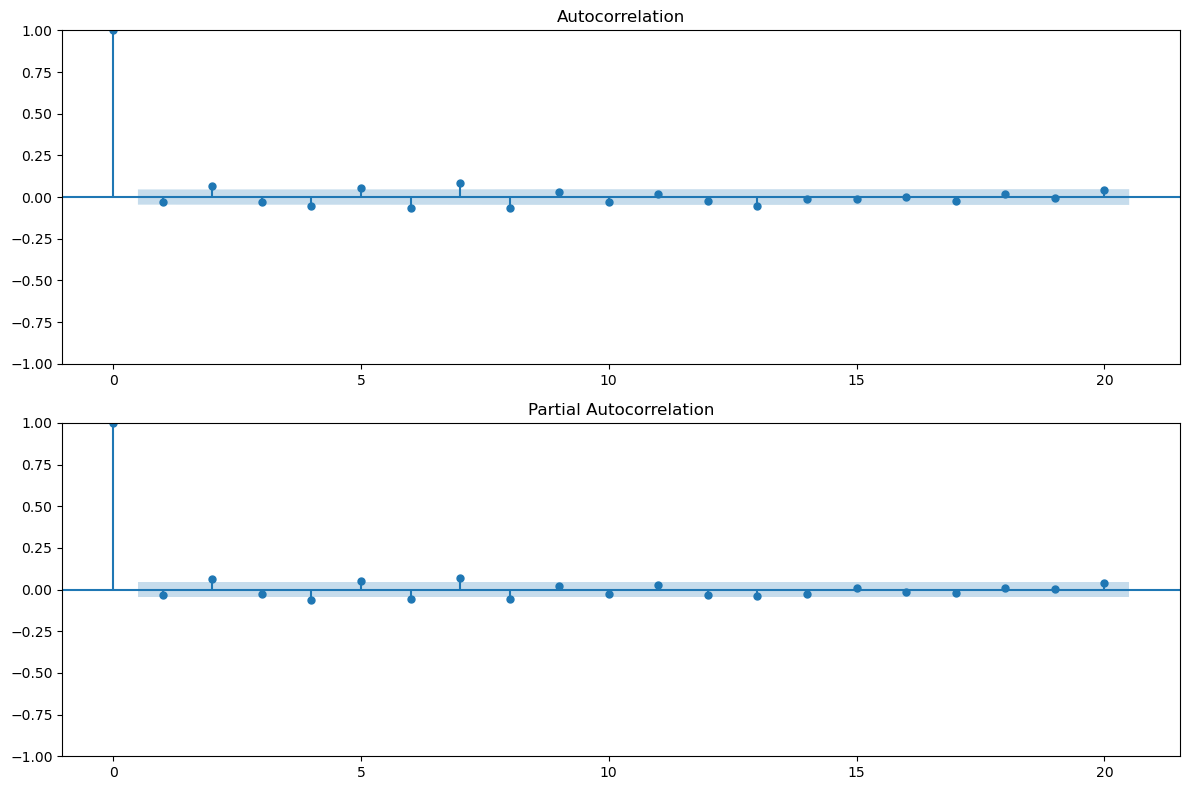

In [49]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(data['Close_diff'].dropna(), lags=20, ax=ax1)
plot_pacf(data['Close_diff'].dropna(), lags=20, ax=ax2)
plt.tight_layout()
plt.show()

##### ACF plot:
##### Ifthere is significant spikes at lag 1, 2, etc., it suggests q.

##### PACF plot:
##### If there is  sharp cutoff after lag 1 (only lag 1 is strong), it suggests p=1.

#### Spikes outside the blue shaded area are considered significant.

###  ARIMA Model Implementation

In [54]:
# Split data into train/test sets
train_size = int(len(data) * 0.8)
train_data = data['Close'][:train_size]
test_data = data['Close'][train_size:]

In [56]:
# Fit ARIMA model (parameters based on ACF/PACF analysis)
model = SARIMAX(train_data, order=(1, 1, 1))
results = model.fit()


C:\Users\ASUS\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ASUS\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [58]:
# Display model summary of seasonal ARIMA
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                    JPM   No. Observations:                 1471
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -3074.589
Date:                Sun, 27 Apr 2025   AIC                           6155.179
Time:                        13:20:32   BIC                           6171.058
Sample:                             0   HQIC                          6161.100
                               - 1471                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4598      0.133     -3.444      0.001      -0.721      -0.198
ma.L1          0.3897      0.136      2.860      0.004       0.123       0.657
sigma2         3.8391      0.073     52.411      0.0

#### ARIMA(1,1,1) model is working nicely
#### we can now go ahead and use it to forecast future JPMorgan stock prices!



### Model Diagnostics

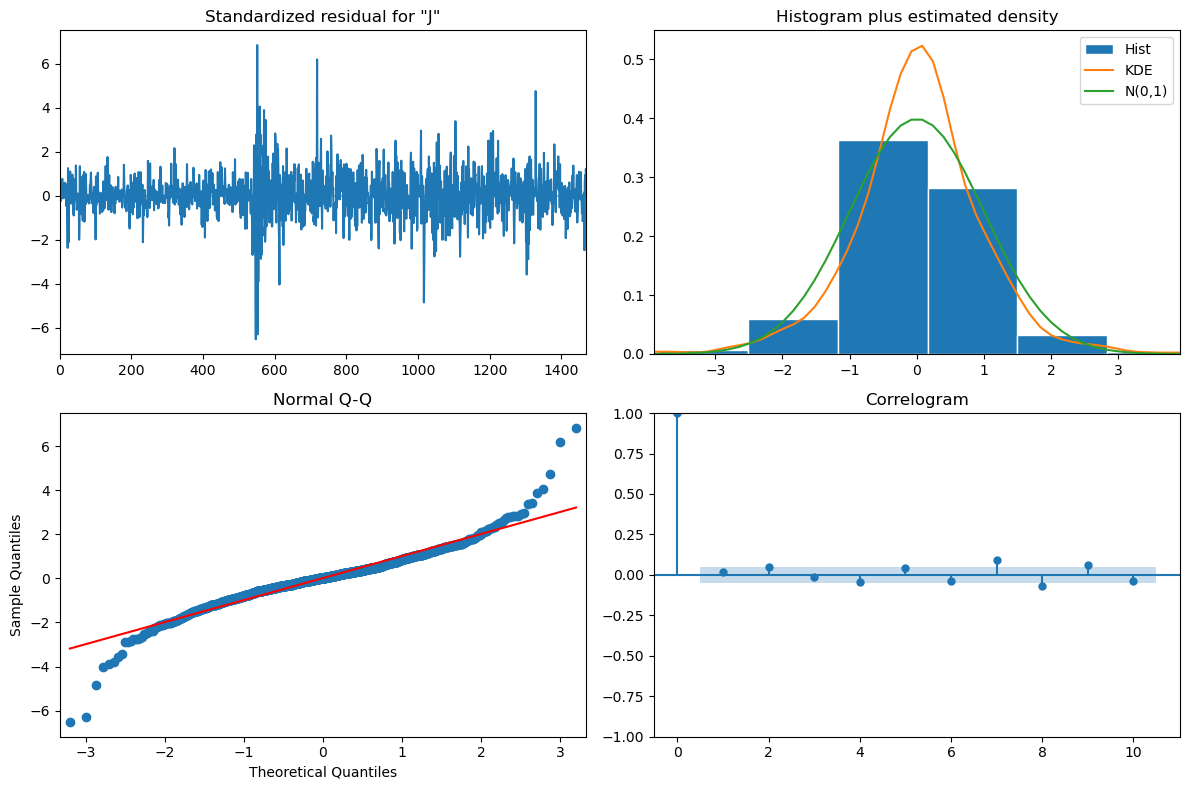

In [63]:
# Plot residual diagnostics
results.plot_diagnostics(figsize=(12, 8))
plt.tight_layout()
plt.show()

###  Forecasting and Validation

In [66]:
# Generate predictions
forecast_steps = len(test_data)
forecast = results.get_forecast(steps=forecast_steps)
forecast_ci = forecast.conf_int()

C:\Users\ASUS\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ASUS\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


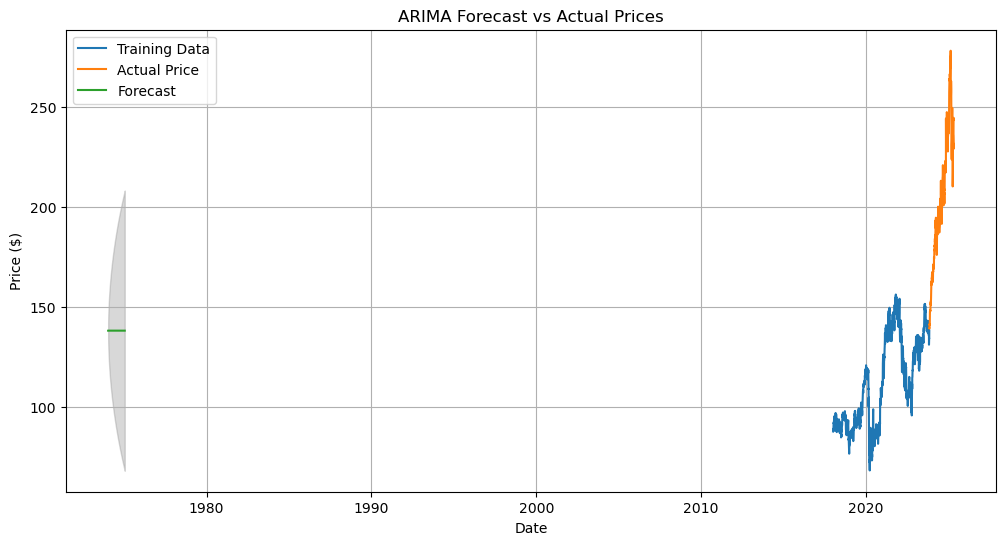

In [68]:
# Plot forecast vs actual
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Actual Price')
plt.plot(forecast.predicted_mean, label='Forecast')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='gray', alpha=0.3)
plt.title('ARIMA Forecast vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

### ARIMA model made reasonable predictions based on past trends, but couldn't fully capture the sharp price rise in the real market.

### Error Metrics Calculation

In [72]:
# Calculate RMSE
rmse = np.sqrt(np.mean((forecast.predicted_mean - test_data)**2))
print(f'\n Root Mean Squared Error (RMSE): {rmse:.2f}\n')

# Calculate MAE
mae = np.mean(np.abs(forecast.predicted_mean - test_data))
print(f'\n Mean Absolute Error (MAE): {mae:.2f}\n')


 Root Mean Squared Error (RMSE): nan


 Mean Absolute Error (MAE): nan



### Tip for Improvement:

### 